# 数据挖掘互评作业四：离群点分析与异常检测

## 1.数据预览(数据集skin)

首先将文件夹下所有数据集的路径读取出来，然后展示第一个数据集的数据

In [6]:
import os
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.pca import PCA
from pyod.models.iforest import IForest
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.utils import column_or_1d,check_consistent_length
from sklearn.metrics import roc_auc_score,precision_score
from pyod.utils.utility import precision_n_scores
import warnings
warnings.filterwarnings("ignore")
root_path = 'skin\\benchmarks'
file_list=[]
for file in os.listdir(root_path):
    file_path = os.path.join(root_path,file)
    file_list.append(file_path)
data = pd.read_csv(file_list[0],index_col=0)
data.head(5)

,motherset,origin,original.label,diff.score,ground.truth,R,G,B
point.id,,,,,,,,
skin_point_117027,skin,binary,2,0.020405,nominal,-1.864336,-2.110524,-1.587289
skin_point_016927,skin,binary,1,0.000250,anomaly,0.384456,0.925785,1.747782
skin_point_240995,skin,binary,2,0.001285,nominal,-0.980882,-1.092860,-1.394351
skin_point_018861,skin,binary,1,0.000739,anomaly,-1.125447,-0.542320,0.383435
skin_point_087883,skin,binary,2,0.001053,nominal,-0.964819,-1.076177,-1.380570


数据集中ground.truth是标签属性，其中nominal代表正常点，anomaly代表异常点，R、G、B三列是特征属性，接下来进一步查看各个属性的详细情况

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, skin_point_117027 to skin_point_007711
Data columns (total 8 columns):
motherset         6000 non-null object
origin            6000 non-null object
original.label    6000 non-null int64
diff.score        6000 non-null float64
ground.truth      6000 non-null object
R                 6000 non-null float64
G                 6000 non-null float64
B                 6000 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 421.9+ KB


可以看出不存在缺失值，不需要进行缺失值处理

## 2.数据可视化

由于三维数据可视化不容易观察，因此采用TSNE降维的方式可视化数据集，可以看出离群点与正常点有着较为明显的界限。

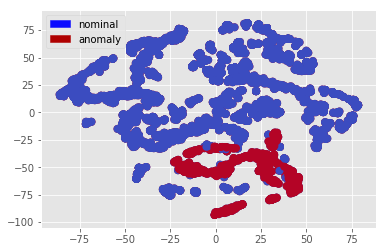

In [15]:
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='#0A0AFF', label='nominal')
red_patch = mpatches.Patch(color='#AF0000', label='anomaly')
X = data[['R','G','B']].values
y = data['ground.truth'].values
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 'nominal'), cmap='coolwarm', label='Normal', linewidths=2)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 'anomaly'), cmap='coolwarm', label='Fraud', linewidths=2)
plt.grid(True)
plt.legend(handles=[blue_patch, red_patch])

## 3.离群点预测

采用的算法如下：

Histogram-based Outlier Score(HBOS):HBOS算法基于多维数据各个维度的独立性假设，对于单个数据维度，先做出数据直方图。对于categroy 值，统计每个值出现的次数，并计算相对频率.

Isolation Forest(IF):该算法利用一种名为孤立树的二叉搜索树结构来孤立样本,异常值的数量较少且与大部分样本的疏离性，因此，异常值会被更早的孤立出来，也即异常值会距离的根节点更近，而正常值则会距离根节点有更远的距离.

k Nearest Neighbors(KNN):如果一个样本在特征空间中的K个最相似（即特征空间中最邻近）的样本中的大多数属于某一个类别，则该样本也属于这个类别。

Local Outlier Factor(LOF):一个样本点周围的样本点所处位置的平均密度比上该样本点所在位置的密度。比值越大于1，则该点所在位置的密度越小于其周围样本所在位置的密度，这个点就越有可能是异常点。

Minimum Covariance Determinant(MCD):一种鲁棒性很强的位置和分布估计算法，并且可以通过FAST-MCD方法高效计算。

Principal Component Analysis(PCA): 是一种统计方法。通过正交变换将一组可能存在相关性的变量转换为一组线性不相关的变量，转换后的这组变量叫主成分。


In [3]:
classifiers_name = ['HBOS','IF','KNN','LOF','MCD','PCA'] 
res = {}
for name in classifiers_name:
    res[name] = {}
    res[name]['roc'] = []
    res[name]['rank_n'] = []
    res[name]['time'] = []
for i,path in enumerate(file_list):
    data = pd.read_csv(path,index_col=0)
    x = data[['R','G','B']].values
    y = data['ground.truth'].values
    y = np.where(y == 'nominal',0,1)
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state = 22,stratify=y)
    outliers_fraction = sum(y_train==1) / len(y_train)
    if outliers_fraction > 0.5:
        continue
    classifiers = {
    'HBOS': HBOS(contamination=outliers_fraction),
    'IF': IForest(contamination=outliers_fraction,random_state = 42),
    'KNN': KNN(contamination=outliers_fraction),
    'LOF':LOF(n_neighbors=35, contamination=outliers_fraction),
    'MCD': MCD(contamination=outliers_fraction, random_state=42),
    'PCA': PCA(contamination=outliers_fraction, random_state=42),
    }
    for clf_name in classifiers:
        start_time = time.time()
        clf = classifiers[clf_name]
        clf.fit(X_train)
        y_test_pred = clf.predict(X_test) 
        y_test_scores = clf.decision_function(X_test) 
        y = column_or_1d(y_test)
        y_pred = column_or_1d(y_test_scores)
        check_consistent_length(y, y_pred)
        roc = np.round(roc_auc_score(y, y_pred), decimals=4)
        prn = np.round(precision_n_scores(y, y_pred), decimals=4)
        run_time = time.time()-start_time
        res[clf_name]['roc'].append(roc)
        res[clf_name]['rank_n'].append(prn)
        res[clf_name]['time'].append(run_time)

对所有数据集分别使用以上六种算法进行训练预测，并保存每个数据集的aug分数，rank_n精度和算法运行时间

## 4.结果可视化

可视化每个算法在单个数据集上的平均aug分数，rank_n精度和算法运行时间

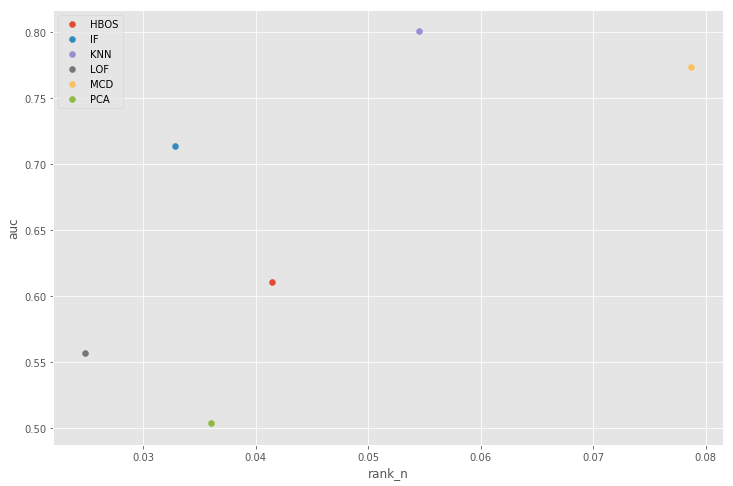

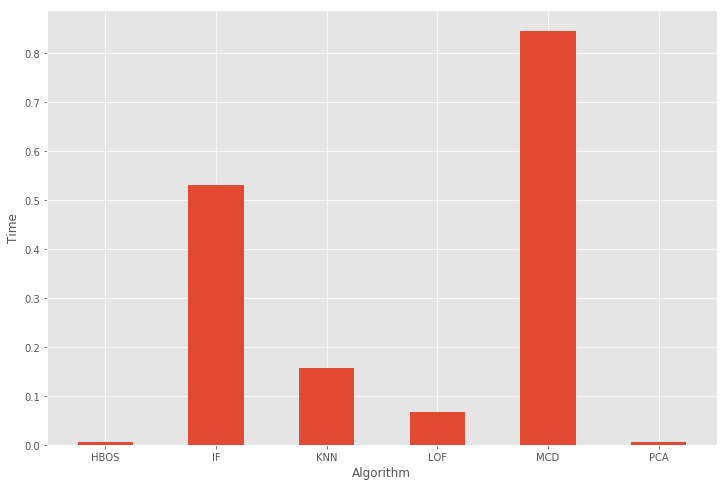

In [4]:
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
name = res.keys()
all_time = []
for v in res.values():
    rank_n = np.mean(v['rank_n'])
    roc = np.mean(v['roc'])
    all_time.append(np.mean(v['time']))
    plt.scatter(rank_n,roc)
plt.xlabel("rank_n")
plt.ylabel("auc")
plt.legend(name)
plt.show()

plt.figure(figsize=(12,8))
plt.bar(name, all_time ,width=0.5)
plt.xlabel("Algorithm")
plt.ylabel("Time")
plt.show()
    

## 5.结果分析

从图一中可以看出KNN和MCD算法都有很好的表现，IF虽然rank_n准确率比较低，但是AUG分数也是比较好的，从时间上来看MCD虽然效果是最好的，但是运行时间也是最长的，而KNN效果很好的同时运行时间也并不长，因此从性价比来看KNN算法是比较适合预测该数据集的。